In [1]:
%matplotlib inline
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix, log_loss, make_scorer
from ipywidgets import widgets
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import math
import os

# Load the model and the dataframes

Dir path:

In [71]:
dir_path = "/data/atlas/atlasdata3/ambroz/VHbb/"

Data path:

In [72]:
data_path = dir_path + "DataFrames/ThesisHybrid/" 

Model path:

In [73]:
model_path = dir_path + "Models/ThesisHybrid/" 

Choose the training category (2 or 3):

In [196]:
njets = 2

Choose ptv region ("150_250", "250, "inclusive"):

In [197]:
#ptv_region = "" #Nothing is the inclusive case
ptv_region = "_ptv_150_250"
#ptv_region = "_ptv_250"

Region names:

In [177]:
region_names = {1 : 'Signal', 2 : 'Top', 3 : 'W', 4 : 'Z', 5  : 'Diboson'}

Analysis color scheme:

In [178]:
colors = {1 : 'C3', 2 : 'C1', 3 : 'C2', 4 : 'C0', 5  : 'C7'}

Load the test DataFrames:

In [179]:
DataFrame_test_fold1 = pd.read_pickle(data_path + 'test' + str(njets) + 'jet' + ptv_region + '_odd.pkl')
DataFrame_test_fold2 = pd.read_pickle(data_path + 'test' + str(njets) + 'jet' + ptv_region + '_even.pkl')

Filter the events:

In [180]:
apply_filter = False
if apply_filter:
    DataFrame_test_fold1 = DataFrame_test_fold1[DataFrame_test_fold1["mBB"] < 500]
    DataFrame_test_fold2 = DataFrame_test_fold2[DataFrame_test_fold2["mBB"] < 500]
    #DataFrame_test_fold1 = DataFrame_test_fold1[DataFrame_test_fold1["dRBB"] < 2.5]
    #DataFrame_test_fold2 = DataFrame_test_fold2[DataFrame_test_fold2["dRBB"] < 2.5]    

In [181]:
DataFrame_test_fold1.head()

pTB1  bin_MV2c10B1        pTB2  bin_MV2c10B2         MET  \
34   532.790955           5.0   81.800095           5.0  479.819153   
78   196.925354           4.0   81.295097           5.0  279.563385   
89   169.863052           5.0  150.729416           4.0  292.305664   
109  177.653748           4.0   91.151436           5.0  256.933716   
145  268.691040           4.0   31.416409           5.0  268.792450   

            MEff         mBB      dRBB    dEtaBB    dPhiBB   dPhiVBB  \
34   1094.410156  400.420929  2.348562  0.320635  2.326571  3.136651   
78    557.783875   84.375351  0.584498  0.563496  0.155275  3.113284   
89    612.898132   88.410469  0.508896  0.015679  0.508655  3.105779   
109   525.738892   92.352783  0.693064  0.103351  0.685315  3.109515   
145   568.899902  164.400177  1.921107  0.842434  1.726545  3.118555   

      dEtaVBB  nTaus  hasFSR    softMET  EventWeight  EventNumber  Class  \
34   1.633945      0     0.0   2.563607     0.000006       182433      5   
78   1.419078      0     0.0   8.389215     0.000002       124635      5   
89   0.023523      1     0.0  20.092226     0.002194       133033      5   
109  1.484951      0     0.0   8.595336     0.000050       140013      5   
145  1.434136      0     0.0   3.895356     0.001238       296385      5   

     NormEventWeight  NormEventWeightOneVsAll  
34      5.169702e-09             1.288621e-10  
78      1.756106e-09             4.377343e-11  
89      2.002570e-06             4.991687e-08  
109     4.524552e-08             1.127808e-09  
145     1.129876e-06             2.816376e-08

Take the column names directly from the DataFrame:

In [182]:
feature_names = list(DataFrame_test_fold1.columns.values)
feature_names.remove("Class")
feature_names.remove("NormEventWeight")
feature_names.remove("EventWeight")
feature_names.remove("EventNumber")
feature_names.remove("NormEventWeightOneVsAll")

In [183]:
feature_names = ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "nTaus", "bin_MV2c10B1", "bin_MV2c10B2", "softMET"] 

if njets == 3:
    feature_names.append("mBBJ")
    feature_names.append("pTJ3")
    feature_names.append("dRBBJ")
else:
    feature_names.append("hasFSR")

Convert DataFrames in numpy arrays:

In [95]:
X_test_fold1 = DataFrame_test_fold1[feature_names].values
Y_test_fold1 = DataFrame_test_fold1[["Class"]].values
Y_weights_test_fold1 = DataFrame_test_fold1[["EventWeight"]].values

X_test_fold2 = DataFrame_test_fold2[feature_names].values
Y_test_fold2 = DataFrame_test_fold2[["Class"]].values
Y_weights_test_fold2 = DataFrame_test_fold2[["EventWeight"]].values

Load the trained module:

In [184]:
if njets == 2 and ptv_region == "_ptv_150_250":
        model_name = "model_XGB_mlogloss_max_depth6_gamma00_learning_rate001_min_child_weight30_jets2_ptv_150_250"
if njets == 2 and ptv_region == "_ptv_250":
        model_name = "model_XGB_mlogloss_max_depth6_gamma00_learning_rate001_min_child_weight10_jets2_ptv_250"
if njets == 3 and ptv_region == "_ptv_150_250":
        model_name = "model_XGB_mlogloss_max_depth8_gamma02_learning_rate001_min_child_weight10_jets3_ptv_150_250"
if njets == 3 and ptv_region == "_ptv_250":
        model_name = "model_XGB_mlogloss_max_depth6_gamma02_learning_rate001_min_child_weight30_jets3_ptv_250"

In [185]:
model_fold1 = pickle.load(open(model_path + model_name + "_fold1.dat", "rb"))
model_fold2 = pickle.load(open(model_path + model_name + "_fold2.dat", "rb"))

Retrive results:

In [17]:
evals_result_fold1 = model_fold1.evals_result()
evals_result_fold2 = model_fold2.evals_result()

Error type:

In [18]:
error = list(evals_result_fold1['validation_0'].keys())[0]
print(error)

mlogloss


Save plots here:

In [198]:
plot_dir = str(njets) + 'njets' + ptv_region + '/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Overtraining check

Check for overtraining:

In [20]:
iterations_fold1 = len(evals_result_fold1['validation_0'][error])
iterations_fold2 = len(evals_result_fold2['validation_0'][error])
x_axis_fold1 = range(0, iterations_fold1)
x_axis_fold2 = range(0, iterations_fold2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plt.sca(axes[0])
plt.plot(x_axis_fold1, evals_result_fold1['validation_0'][error], label='Train fold 1')
plt.plot(x_axis_fold1, evals_result_fold1['validation_1'][error], label='Validation fold 1', color = 'g')
plt.legend()
plt.ylabel('Loss function') #error
plt.xlabel('Training iterations')
#plt.title(error)

plt.sca(axes[1])
plt.plot(x_axis_fold2, evals_result_fold2['validation_0'][error], label='Train fold 2')
plt.plot(x_axis_fold2, evals_result_fold2['validation_1'][error], label='Validation fold 2', color = 'g')
plt.legend()
plt.ylabel('Loss function') #error
plt.xlabel('Training iterations')
#plt.title(error)

plt.savefig(plot_dir + 'overtraining.pdf')

Minimum of the validation sets:

In [21]:
print(min(evals_result_fold1['validation_1'][error]))
print(min(evals_result_fold2['validation_1'][error]))

0.71002
0.721981


# Performance evaluation

Best iterations:

In [22]:
print(model_fold1.best_ntree_limit)
print(model_fold2.best_ntree_limit)

2646
2037


Best scores:

In [23]:
print(model_fold1.best_score)
print(model_fold2.best_score)

0.71002
0.721981


Make predictions of the test dataset using the best model (default for ntree_limit=0):

In [24]:
Y_test_predictions_fold1 = model_fold1.predict(X_test_fold1, ntree_limit=model_fold1.best_ntree_limit)
Y_test_predictions_proba_fold1 = model_fold1.predict_proba(X_test_fold1, ntree_limit=model_fold1.best_ntree_limit)

Y_test_predictions_fold2 = model_fold2.predict(X_test_fold2, ntree_limit=model_fold2.best_ntree_limit)
Y_test_predictions_proba_fold2 = model_fold2.predict_proba(X_test_fold2, ntree_limit=model_fold2.best_ntree_limit)

Evaluate the logloss of the predictions:

In [25]:
accuracy_fold1 = log_loss(Y_test_fold1.ravel(), Y_test_predictions_proba_fold1, sample_weight = Y_weights_test_fold1.ravel())
print("test log_loss_fold1: %.4f" % (accuracy_fold1))

accuracy_fold2 = log_loss(Y_test_fold2.ravel(), Y_test_predictions_proba_fold2, sample_weight = Y_weights_test_fold2.ravel())
print("test log_loss_fold2: %.4f" % (accuracy_fold2))

test log_loss_fold1: 1.3150
test log_loss_fold2: 1.3087


Add to the DataFrames for test the class predicted and the probabilities for any given class:

In [26]:
DataFrame_test_fold1['Predicted class'] = Y_test_predictions_fold1.tolist()
DataFrame_test_fold2['Predicted class'] = Y_test_predictions_fold2.tolist()

In [27]:
DataFrame_test_fold1['Prob class 1'] = Y_test_predictions_proba_fold1[:,0].tolist() #Get the column 0
DataFrame_test_fold1['Prob class 2'] = Y_test_predictions_proba_fold1[:,1].tolist() #Get the column 1
DataFrame_test_fold1['Prob class 3'] = Y_test_predictions_proba_fold1[:,2].tolist() #Get the column 2
DataFrame_test_fold1['Prob class 4'] = Y_test_predictions_proba_fold1[:,3].tolist() #Get the column 3
DataFrame_test_fold1['Prob class 5'] = Y_test_predictions_proba_fold1[:,4].tolist() #Get the column 4

DataFrame_test_fold2['Prob class 1'] = Y_test_predictions_proba_fold2[:,0].tolist() #Get the column 0
DataFrame_test_fold2['Prob class 2'] = Y_test_predictions_proba_fold2[:,1].tolist() #Get the column 1
DataFrame_test_fold2['Prob class 3'] = Y_test_predictions_proba_fold2[:,2].tolist() #Get the column 2
DataFrame_test_fold2['Prob class 4'] = Y_test_predictions_proba_fold2[:,3].tolist() #Get the column 3
DataFrame_test_fold2['Prob class 5'] = Y_test_predictions_proba_fold2[:,4].tolist() #Get the column 4

In [28]:
DataFrame_test_fold1.head()

pTB1  bin_MV2c10B1       pTB2  bin_MV2c10B2         MET        MEff  \
3   178.117538           5.0  36.869427           4.0  209.984085  424.971069   
4   162.761917           4.0  26.818243           4.0  154.618011  344.198181   
11  121.807892           4.0  34.941181           4.0  151.422821  308.171906   
12  172.506531           4.0  47.030144           4.0  154.006378  373.543060   
14  182.518448           4.0  30.607927           4.0  151.168076  364.294464   

           mBB      dRBB    dEtaBB    dPhiBB  ...  EventNumber  Class  \
3    48.575466  0.450391  0.448787  0.037977  ...       103191      5   
4   140.704163  2.343615  1.161875  2.035332  ...       102195      5   
11   96.059860  1.308642  1.251871  0.381264  ...       102337      5   
12   84.399628  0.914919  0.705037  0.583095  ...       109223      5   
14  111.325279  1.539986  0.719568  1.361536  ...       108551      5   

    NormEventWeight  NormEventWeightOneVsAll  Predicted class  Prob class 1  \
3      2.830640e-09             7.055768e-11                4      0.031962   
4      1.344729e-09             3.351925e-11                4      0.195652   
11     7.566707e-10             1.886108e-11                4      0.245064   
12     1.071762e-09             2.671517e-11                2      0.179459   
14     2.901930e-08             7.233470e-10                1      0.567245   

    Prob class 2  Prob class 3  Prob class 4  Prob class 5  
3       0.017434      0.259757      0.687526      0.003322  
4       0.044112      0.279429      0.476679      0.004127  
11      0.186717      0.125759      0.390406      0.052054  
12      0.581588      0.070822      0.072840      0.095292  
14      0.090149      0.311401      0.024151      0.007054  

[5 rows x 26 columns]

# Sum the two folds

In [29]:
DataFrame_test_fold12 = pd.concat([DataFrame_test_fold1, DataFrame_test_fold2], ignore_index = True)

In [30]:
X_test_fold12 = np.concatenate([X_test_fold1, X_test_fold2])
Y_test_fold12 = np.concatenate([Y_test_fold1, Y_test_fold2])
Y_weights_test_fold12 = np.concatenate([Y_weights_test_fold1, Y_weights_test_fold2])

In [31]:
Y_test_predictions_fold12 = np.concatenate([Y_test_predictions_fold1, Y_test_predictions_fold2])
Y_test_predictions_proba_fold12 = np.concatenate([Y_test_predictions_proba_fold1, Y_test_predictions_proba_fold2])

# Purity

In [32]:
fig, ax = plt.subplots(figsize = (12,12))

ind = np.arange(5)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

#The test sample contains half of the events. Should multiplied for 2 to get back yields.
SignalYieldsForClasses  = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 1].groupby("Predicted class")["EventWeight"].sum() 
TopYieldsForClasses     = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 2].groupby("Predicted class")["EventWeight"].sum() 
WYieldsForClasses       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 3].groupby("Predicted class")["EventWeight"].sum() 
ZYieldsForClasses       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 4].groupby("Predicted class")["EventWeight"].sum() 
DibosonYieldsForClasses = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 5].groupby("Predicted class")["EventWeight"].sum() 

SignalComp   = plt.bar(ind, SignalYieldsForClasses, width, color = colors[1])
TopComp      = plt.bar(ind, TopYieldsForClasses, width, bottom = SignalYieldsForClasses, color = colors[2])
WComp        = plt.bar(ind, WYieldsForClasses , width, bottom = SignalYieldsForClasses + TopYieldsForClasses, color = colors[3])
ZComp        = plt.bar(ind, ZYieldsForClasses, width, bottom = SignalYieldsForClasses + TopYieldsForClasses + WYieldsForClasses, color = colors[4])
DibosonComp  = plt.bar(ind, DibosonYieldsForClasses, width, bottom = SignalYieldsForClasses + TopYieldsForClasses + WYieldsForClasses + ZYieldsForClasses, color = colors[5])

column_heights = []
for s, t, w, z, d in zip(SignalComp, TopComp, WComp, ZComp, DibosonComp):
    height = s.get_height() + t.get_height() + w.get_height() + z.get_height() + d.get_height()
    column_heights.append(height)

offset_label = max(column_heights) * 0.02
ax.text(0, column_heights[0] + offset_label, "Purity " + str(round(SignalComp[0].get_height()  / column_heights[0] * 100,2)) + "%", ha='center', va='top')
ax.text(1, column_heights[1] + offset_label, "Purity " + str(round(TopComp[1].get_height()     / column_heights[1] * 100,2)) + "%", ha='center', va='top')
ax.text(2, column_heights[2] + offset_label, "Purity " + str(round(WComp[2].get_height()       / column_heights[2] * 100,2)) + "%", ha='center', va='top')
ax.text(3, column_heights[3] + offset_label, "Purity " + str(round(ZComp[3].get_height()       / column_heights[3] * 100,2)) + "%", ha='center', va='top')
ax.text(4, column_heights[4] + offset_label, "Purity " + str(round(DibosonComp[4].get_height() / column_heights[4] * 100,2)) + "%", ha='center', va='top')

if ptv_region == "_ptv_150_250":
    plt.title('0 Lepton, 2tag' + str(njets) + 'jet, 150GeV < ptv < 250GeV')
if ptv_region == "_ptv_250":
    plt.title('0 Lepton, 2tag' + str(njets) + 'jet, ptv > 250GeV')    

plt.xlabel('Predicted classes')
plt.ylabel('Yields')

plt.xticks(ind, ('Signal', 'Top', 'W', 'Z', 'Diboson'))
plt.legend((SignalComp, TopComp, WComp, ZComp, DibosonComp), ('True signal', 'True top', 'True W', 'True Z', 'True diboson'))
plt.savefig(plot_dir + 'purity.pdf')

Plot mva scores for the test set:

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(17, 14)) #Axes are numerated from 0 to 5.

axes = axes.ravel()

for i in range(1,6): 
    for j in range(1,6):
        DataFrame_test_class_j = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == j]
        DataFrame_test_class_j['Prob class ' + str(i)].plot.hist(ax=axes[i-1], 
                                                                 color = colors[j],
                                                                 bins=15, 
                                                                 range=(0,1),
                                                                 ylim = (0.001, 5000),
                                                                 histtype=u'step', 
                                                                 legend=True, 
                                                                 weights = DataFrame_test_class_j['EventWeight'],
                                                                 density = True
                                                                )
    
    axes[i-1].legend(('Signal','Top','W','Z','Diboson'), loc='best')
    axes[i-1].set_yscale('log')
    #axes[i-1].set_title('True ' + region_names[i], x=0.5, y=0.9)
    axes[i-1].set_xlabel('Prob '   + region_names[i], x=0.9, y=0.6)
    axes[i-1].set_ylabel('a.u.')
    
    
fig.delaxes(axes[5]) #Delete the sixth canvas. 
fig.savefig(plot_dir + 'scores.pdf')

Yields:

In [34]:
TotEventWeightSignal  = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 1]["EventWeight"].sum()
TotEventWeightTop     = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 2]["EventWeight"].sum()
TotEventWeightW       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 3]["EventWeight"].sum()
TotEventWeightZ       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 4]["EventWeight"].sum()
TotEventWeightDiboson = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 5]["EventWeight"].sum()

# Feature importances

F score (this is a metric that simply sums up how many times each feature is split on) normalised to 1:

In [187]:
#fig, axes = plt.subplots(1, 2)
fig, axes = plt.subplots(1, 1)

DataFrameFeatures = pd.DataFrame([feature_names, list(model_fold1.feature_importances_)]).T
DataFrameFeatures.columns = ['feature_name', 'feature_score']
DataFrameFeatures.sort_values('feature_score', ascending = False, inplace = True)
DataFrameFeatures.set_index('feature_name', inplace = True)
#plot = DataFrameFeatures.plot(kind='bar', legend = False, title = 'Model fold 1', figsize=(16, 5), ax=axes[0])
plot = DataFrameFeatures.plot(kind='bar', legend = False, title = 'Model fold 1', figsize=(8, 3), ax=axes)
plot.set_ylabel('Feature importance')
plot.set_xlabel('Feature')

#DataFrameFeatures = pd.DataFrame([feature_names, list(model_fold2.feature_importances_)]).T
#DataFrameFeatures.columns = ['feature_name', 'feature_score']
#DataFrameFeatures.sort_values('feature_score', ascending = False, inplace = True)
#DataFrameFeatures.set_index('feature_name', inplace = True)
#plot = DataFrameFeatures.plot(kind='bar', legend = False, title = 'Model fold 2', figsize=(16, 5), ax=axes[1])
#plot.set_ylabel('Feature importance')
#plot.set_xlabel('Feature')

fig.savefig(plot_dir + 'ranking.pdf', bbox_inches='tight')

# ROC curves

Compute ROC curve and ROC area for each class:

In [36]:
fpr1 = dict() #False positive rate
tpr1 = dict() #True positive rate
fpr2 = dict() 
tpr2 = dict() 
fpr12 = dict() 
tpr12 = dict() 

roc_auc1 = dict()
roc_auc2 = dict()
roc_auc12 = dict()

for i in range(1,6):
    Y_test_class_i_fold1 = Y_test_fold1 == i
    fpr1[i], tpr1[i], _ = roc_curve(Y_test_class_i_fold1[:,0], Y_test_predictions_proba_fold1[:, i-1], sample_weight = abs(Y_weights_test_fold1))
    roc_auc1[i] = auc(fpr1[i], tpr1[i])
    
    Y_test_class_i_fold2 = Y_test_fold2 == i
    fpr2[i], tpr2[i], _ = roc_curve(Y_test_class_i_fold2[:,0], Y_test_predictions_proba_fold2[:, i-1], sample_weight = abs(Y_weights_test_fold2))
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
    Y_test_class_i_fold12 = Y_test_fold12 == i
    fpr12[i], tpr12[i], _ = roc_curve(Y_test_class_i_fold12[:,0], Y_test_predictions_proba_fold12[:, i-1], sample_weight = abs(Y_weights_test_fold12))
    roc_auc12[i] = auc(fpr12[i], tpr12[i])

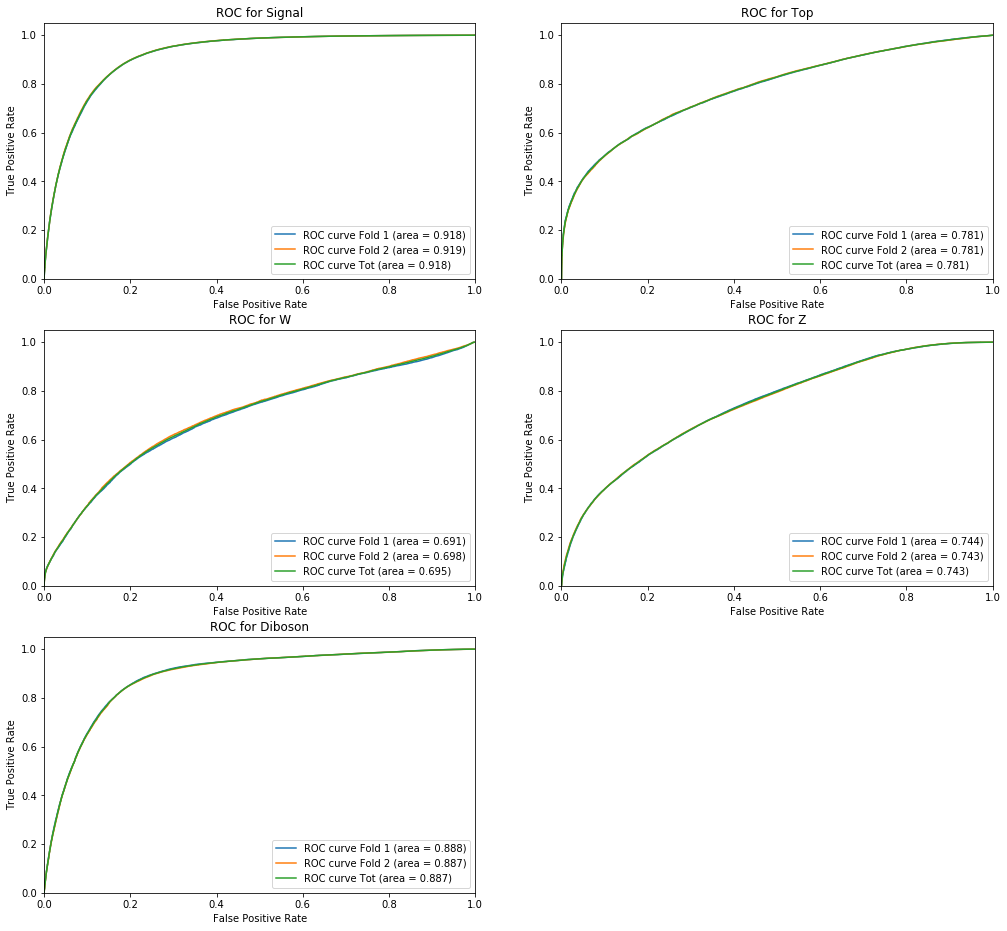

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(17, 16)) #Axes are numerated from 0 to 5.

axes = axes.ravel()
for i in range(1,6):
    plt.sca(axes[i-1])
    plt.plot(fpr1[i], tpr1[i], label='ROC curve Fold 1 (area = %0.3f)' % roc_auc1[i])
    plt.plot(fpr2[i], tpr2[i], label='ROC curve Fold 2 (area = %0.3f)' % roc_auc2[i])
    plt.plot(fpr12[i], tpr12[i], label='ROC curve Tot (area = %0.3f)' % roc_auc12[i])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + region_names[i])
    plt.legend(loc="lower right")

fig.delaxes(axes[5]) #Delete the sixth canvas.
fig.savefig(plot_dir + 'ROC.pdf')

# Trafo D binning

In [38]:
histSignal, binsS = np.histogram(DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 1]['Prob class 1'], bins=1000, range=(0,1), weights = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 1]['EventWeight'])
histBgkT, binsT   = np.histogram(DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 2]['Prob class 1'], bins=1000, range=(0,1), weights = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 2]['EventWeight'])
histBgkW, binsW   = np.histogram(DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 3]['Prob class 1'], bins=1000, range=(0,1), weights = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 3]['EventWeight'])
histBgkZ, binsZ   = np.histogram(DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 4]['Prob class 1'], bins=1000, range=(0,1), weights = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 4]['EventWeight'])
histBgkD, binsD   = np.histogram(DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 5]['Prob class 1'], bins=1000, range=(0,1), weights = DataFrame_test_fold12[DataFrame_test_fold12['Class'] == 5]['EventWeight'])
histBgkTot = histBgkT + histBgkW + histBgkZ + histBgkD 

In [39]:
def TrafoD(histSignal, histBgkTot, bins_edges): #Make sure the two histos have the same binning
    zs = 10
    zb = 5
    
    Ns = histSignal.sum()
    Nb = histBgkTot.sum()
    
    ns = 0
    nb = 0
    
    newHistSignalTot = []
    newHistBgkTot    = []
    
    new_bins_edges = []
    new_bins_edges.append(bins_edges[-1])
    np.delete(bins_edges, -1)
    
    for s, b, bin_edge in zip(reversed(histSignal), reversed(histBgkTot), reversed(bins_edges)):
            ns += s
            nb += b
            if (zs * ns / Ns + zb * nb / Nb) > 1:
                new_bins_edges.append(bin_edge)
                ns = 0
                nb = 0
                
            try:
                newHistSignalTot[len(new_bins_edges)-1] += s
                newHistBgkTot   [len(new_bins_edges)-1] += b
            except IndexError:
                newHistSignalTot.append(0)
                newHistBgkTot.append(0)
                newHistSignalTot[len(new_bins_edges)-1] += s
                newHistBgkTot   [len(new_bins_edges)-1] += b
            
    if new_bins_edges[-1] != 0:
        new_bins_edges.append(0)
        
    new_bins_edges.reverse()
    newHistSignalTot.reverse()
    newHistBgkTot.reverse()
    
    new_bins_edges = np.array(new_bins_edges)
    newHistSignalTot = np.array(newHistSignalTot)
    newHistBgkTot = np.array(newHistBgkTot)
    
    return new_bins_edges, newHistSignalTot, newHistBgkTot

In [40]:
TrafoD_bins_edges, TrafoD_HistSignalTot, TrafoD_HistBgkTot = TrafoD(histSignal, histBgkTot, binsS)

# Significance

In [41]:
def compute_significance(hist_s, hist_bkg): #Make sure the two histos have the same binning
    
    rad = 0
    for ns_i, nb_i in zip(hist_s, hist_bkg):
        rad += (ns_i + nb_i)*math.log(1+ ns_i / nb_i) - ns_i
        
    S = math.sqrt(2*rad)
    
    return S

Compute and save significance:

In [42]:
significance = compute_significance(TrafoD_HistSignalTot, TrafoD_HistBgkTot)
message = "Significance for " + str(njets) + "jets, ptv region " + ptv_region + ": " + str(significance)
print(message)

f = open(plot_dir + 'significance.txt', "w")
f.write(message)
f.close()

Significance for 2jets, ptv region _ptv_150_250: 4.0032351905185495


# MVA inputs plots

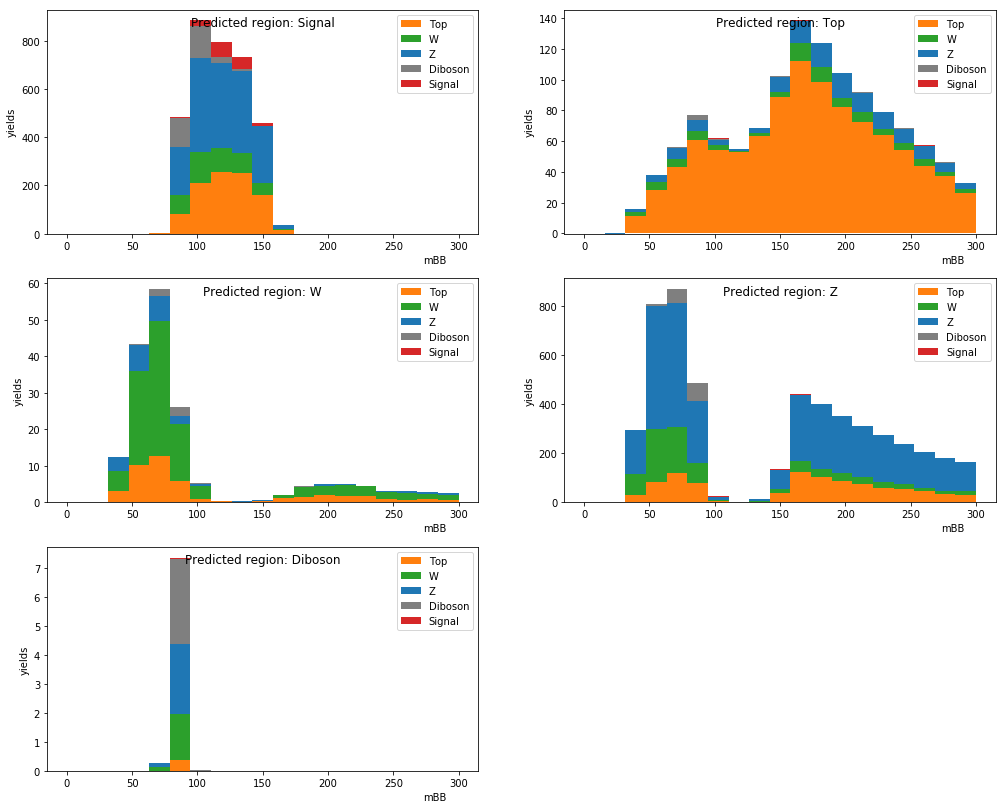

In [43]:
var = "mBB"

fig, axes = plt.subplots(3, 2, figsize=(17, 14)) #Axes are numerated from 0 to 5.
axes = axes.ravel()

for predicted_region in range(1,6):
    
    plt.sca(axes[predicted_region-1])
    
    bins = np.linspace(0, 300, 20)
    #bins = [-0.5,0.5,1.5,2.5,3.5,4.5]
    #bins = TrafoD_bins_edges
    
    #The test sample contains half of the events. Should multiplied for 2 to get back yields.
    SignalVarForPredicedClass       = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1) & (DataFrame_test_fold12["Predicted class"] == predicted_region)][var]
    SignalWeightsForPredicedClass   = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1) & (DataFrame_test_fold12["Predicted class"] == predicted_region)]["EventWeight"]
    TopVarForPredicedClass          = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2) & (DataFrame_test_fold12["Predicted class"] == predicted_region)][var]
    TopWeightsForPredicedClass      = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2) & (DataFrame_test_fold12["Predicted class"] == predicted_region)]["EventWeight"]
    WVarForPredicedClass            = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3) & (DataFrame_test_fold12["Predicted class"] == predicted_region)][var]
    WWeightsForPredicedClass        = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3) & (DataFrame_test_fold12["Predicted class"] == predicted_region)]["EventWeight"]
    ZVarForPredicedClass            = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4) & (DataFrame_test_fold12["Predicted class"] == predicted_region)][var]
    ZWeightsForPredicedClass        = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4) & (DataFrame_test_fold12["Predicted class"] == predicted_region)]["EventWeight"]
    DibosonVarForPredicedClass      = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5) & (DataFrame_test_fold12["Predicted class"] == predicted_region)][var]
    DibosonWeightsForPredicedClass  = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5) & (DataFrame_test_fold12["Predicted class"] == predicted_region)]["EventWeight"]
    
    plt.hist([TopVarForPredicedClass, WVarForPredicedClass, ZVarForPredicedClass, DibosonVarForPredicedClass, SignalVarForPredicedClass], 
              bins, 
              weights = [TopWeightsForPredicedClass, WWeightsForPredicedClass, ZWeightsForPredicedClass, DibosonWeightsForPredicedClass, SignalWeightsForPredicedClass], 
              color = [colors[2], colors[3], colors[4], colors[5], colors[1]],
              ###Hist type###
              #histtype = 'step', 
              stacked = True,
              density = False,
              ###############
              label = ['Top','W','Z','Diboson','Signal'],
            )
    
    plt.gca().legend()
    plt.title('Predicted region: ' + str(region_names[predicted_region]), x=0.5, y=0.9)
    plt.xlabel(var, x=0.9, y=0.6)
    plt.ylabel('yields')
    #plt.ylabel('a.u')
    #plt.ylim((0,1000))
    

fig.delaxes(axes[5]) #Delete the sixth canvas.     
fig.savefig(plot_dir +  var + '_in_predicted_regions.pdf')

# MVA plot

In [44]:
fig, ax = plt.subplots()
a, b, c = plt.hist([DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2)]["Prob class 1"],
                    DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3)]["Prob class 1"],
                    DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4)]["Prob class 1"],
                    DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5)]["Prob class 1"],
                    DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1)]["Prob class 1"]],
                    bins = TrafoD_bins_edges,
                    weights = [DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2)]["EventWeight"],
                               DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3)]["EventWeight"],
                               DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4)]["EventWeight"],
                               DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5)]["EventWeight"],
                               DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1)]["EventWeight"]],
                   color = [colors[2], colors[3], colors[4], colors[5], colors[1]],
                   ###Hist type###
                   histtype = 'step', 
                   stacked = False,
                   density = False,
                   ###############
                   label = ['Top','W','Z','Diboson','Signal'],
                  )
plt.close()

fig, ax = plt.subplots(figsize=(10, 6))
width = 1
ind = np.arange(15) 
Top = plt.bar(ind, a[0], width, color = colors[2]) #Top
W = plt.bar(ind, a[1], width, bottom = a[0], color = colors[3]) #W
Z = plt.bar(ind, a[2], width, bottom = a[0] + a[1], color = colors[4]) #Z
Diboson = plt.bar(ind, a[3], width, bottom = a[0] + a[1] + a[2], color = colors[5]) #Diboson
Signal = plt.bar(ind, a[4], width, bottom = a[0] + a[1] + a[2] + a[3], color = colors[1]) #Signal
plt.plot(ind+0.5, a[4], color = colors[1], ls='steps') #Signal shape
plt.legend((Signal, Top, W, Z, Diboson), ('Signal', 'Top', 'W', 'Z', 'Diboson'))
plt.ylim((2,10000))
ax.set_yscale('log')
ax.set_xlabel('BDT bins', x=0.9, y=0.6)
ax.set_ylabel('Yields')
plt.savefig(plot_dir + 'mvaSignal.pdf')

# Top and W CRs

Define two arbitrary thresholds for the Top and W CRs:

In [45]:
def isTopOrWCR(t, w):
    
    ###Arbitrary values (keep them bigger than 0.5)
    t_threshold = 0.3
    w_threshold = 0.3
    
    if t > t_threshold and w < w_threshold:
        return 2
    elif w > w_threshold and t < t_threshold:
        return 3
    elif w > w_threshold and t > t_threshold:
        if t > w:
            return 2
        else:
            return 3
    
    return 1

In [46]:
DataFrame_test_fold12['isTopOrWCR'] = DataFrame_test_fold12.apply(lambda row: isTopOrWCR(row['Prob class 2'], row['Prob class 3']), axis=1)

In [47]:
fig, ax = plt.subplots(figsize = (12,12))

ind = np.arange(3)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

#The test sample contains half of the events. Should multiplied for 2 to get back yields.
SignalYieldsForClasses  = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 1].groupby("isTopOrWCR")["EventWeight"].sum()
TopYieldsForClasses     = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 2].groupby("isTopOrWCR")["EventWeight"].sum()
WYieldsForClasses       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 3].groupby("isTopOrWCR")["EventWeight"].sum()
ZYieldsForClasses       = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 4].groupby("isTopOrWCR")["EventWeight"].sum()
DibosonYieldsForClasses = DataFrame_test_fold12[DataFrame_test_fold12["Class"] == 5].groupby("isTopOrWCR")["EventWeight"].sum()

SignalComp   = plt.bar(ind, SignalYieldsForClasses, width, color = colors[1])
TopComp      = plt.bar(ind, TopYieldsForClasses, width, bottom = SignalYieldsForClasses, color = colors[2])
WComp        = plt.bar(ind, WYieldsForClasses , width, bottom = SignalYieldsForClasses + TopYieldsForClasses, color = colors[3])
ZComp        = plt.bar(ind, ZYieldsForClasses, width, bottom = SignalYieldsForClasses + TopYieldsForClasses + WYieldsForClasses, color = colors[4])
DibosonComp  = plt.bar(ind, DibosonYieldsForClasses, width, bottom = SignalYieldsForClasses + TopYieldsForClasses + WYieldsForClasses + ZYieldsForClasses, color = colors[5])

column_heights = []
for s, t, w, z, d in zip(SignalComp, TopComp, WComp, ZComp, DibosonComp):
    height = s.get_height() + t.get_height() + w.get_height() + z.get_height() + d.get_height()
    column_heights.append(height)

offset_label = max(column_heights) * 0.02
ax.text(0, column_heights[0] + offset_label, "Signal purity: " + str(round(SignalComp[0].get_height()  / column_heights[0] * 100,2)) + "%", ha='center', va='top')
ax.text(1, column_heights[1] + offset_label, "Top purity: " + str(round(TopComp[1].get_height()     / column_heights[1] * 100,2)) + "%", ha='center', va='top')
ax.text(2, column_heights[2] + offset_label, "W purity: " + str(round(WComp[2].get_height()       / column_heights[2] * 100,2)) + "%", ha='center', va='top')

ax.text(1, column_heights[1] +  2 * offset_label, "Top CR / Top SR: " + str(round(TopComp[1].get_height() / TopComp[0].get_height() * 100, 2)) + "%", ha='center', va='top')
ax.text(2, column_heights[2] +  2 * offset_label, "W CR / W SR: " + str(round(WComp[2].get_height() / WComp[0].get_height() * 100, 2)) + "%", ha='center', va='top')

ax.text(1, column_heights[1] +  3 * offset_label, "Yields Top CR / Yields SR: " + str(round(column_heights[1] / column_heights[0] * 100, 2)) + "%", ha='center', va='top')
ax.text(2, column_heights[2] +  3 * offset_label, "Yields W CR / Yields SR: " + str(round(column_heights[2] / column_heights[0] * 100, 2)) + "%", ha='center', va='top')

ax.text(1, column_heights[1] +  4 * offset_label, "Signal contamination: " + str(round(SignalComp[1].get_height() / column_heights[1] * 100, 2)) + "%", ha='center', va='top')
ax.text(2, column_heights[2] +  4 * offset_label, "Signal contamination: " + str(round(SignalComp[2].get_height() / column_heights[2] * 100, 2)) + "%", ha='center', va='top')

if ptv_region == "_ptv_150_250":
    plt.title('0 Lepton, 2tag' + str(njets) + 'jet, 150GeV < ptv < 250GeV')
if ptv_region == "_ptv_250":
    plt.title('0 Lepton, 2tag' + str(njets) + 'jet, ptv > 250GeV')    

plt.xlabel('Predicted classes')
plt.ylabel('Yields')
#plt.ylim((0.1,21000))

plt.xticks(ind, ('SR', 'Top CR', 'W CR'))
plt.legend((SignalComp, TopComp, WComp, ZComp, DibosonComp), ('True signal', 'True top', 'True W', 'True Z', 'True Diboson'))
plt.savefig(plot_dir + 'purity_top_w_cr_' + str(njets) + 'jets' + ptv_region + '.pdf')

# Input var in Top and W CRs

Bins:

In [48]:
bins = {
    "mBB" : np.linspace(0, 300, 60), #Min, max, bins
    "mB1" : np.linspace(0, 200, 20),
    "mB2" : np.linspace(0, 100, 20),
    "pTB1" : np.linspace(0, 400, 40),
    "pTB2" : np.linspace(0, 300, 30),
    "MET" : np.linspace(0, 400, 50),
    "MEff" : np.linspace(0, 600, 30),
    "dRBB" : np.linspace(0, 3, 30),
    "dEtaBB" : np.linspace(0, 5, 30),
    "dPhiVBB" : np.linspace(1.6, 3.2, 16),
    "nTaus" : [-0.5,0.5,1.5,2.5,3.5,4.5]
}

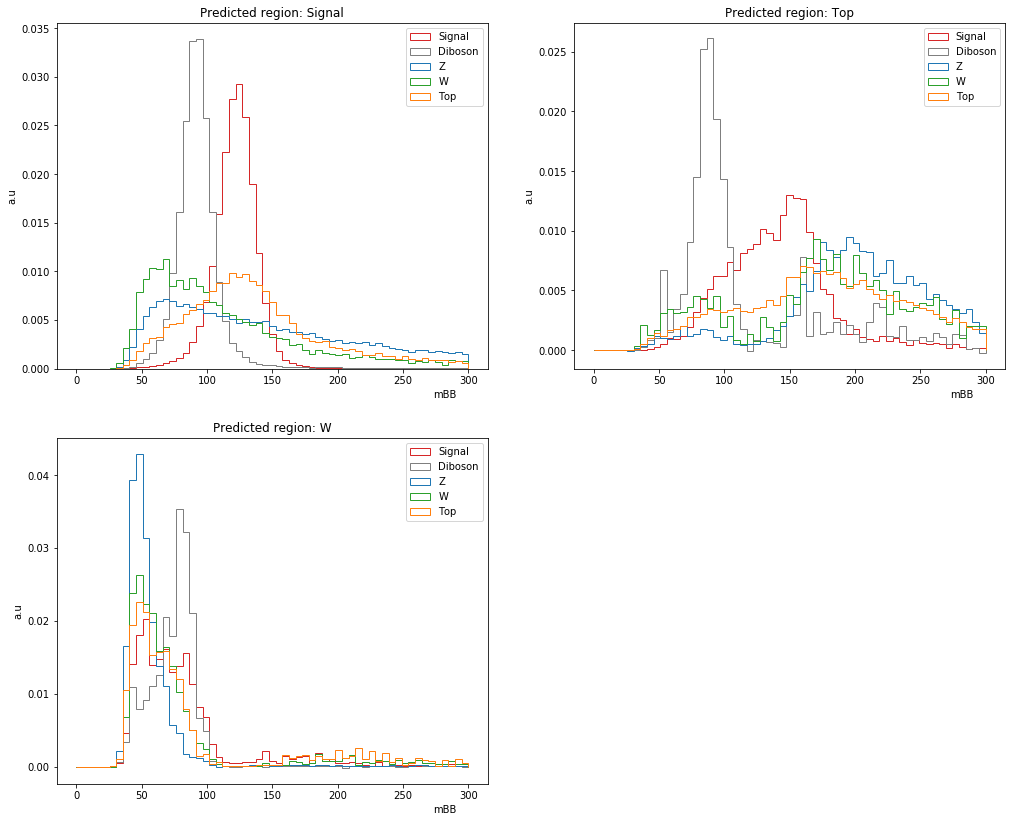

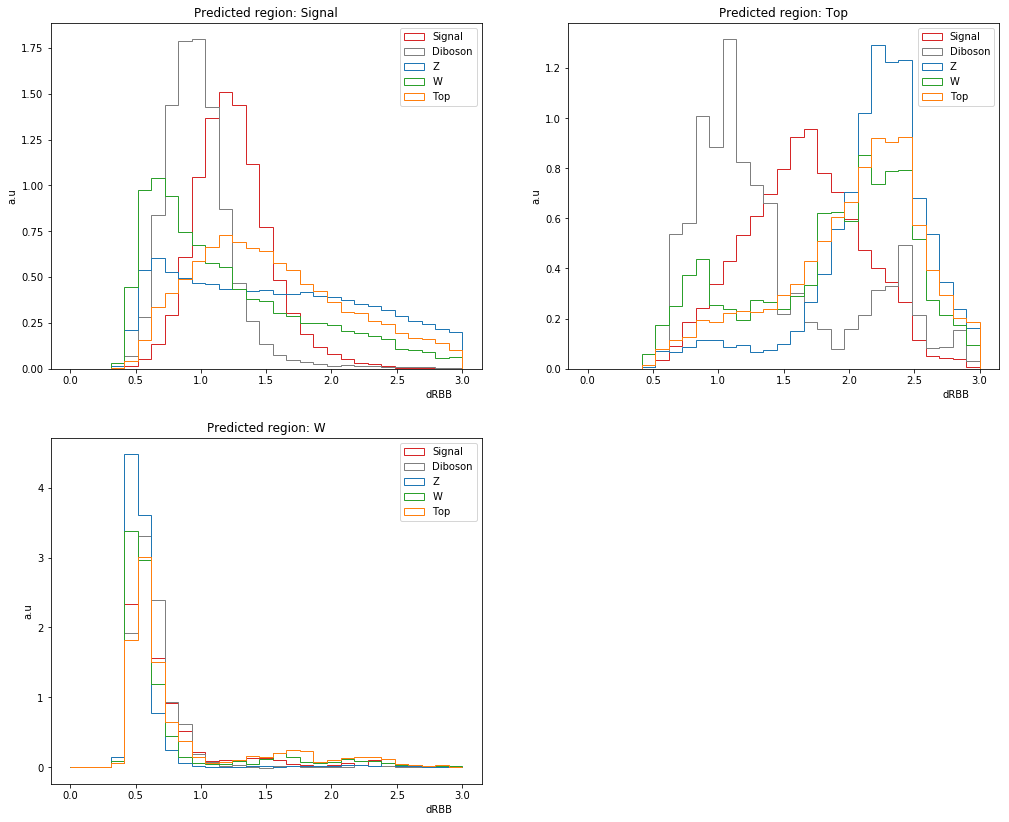

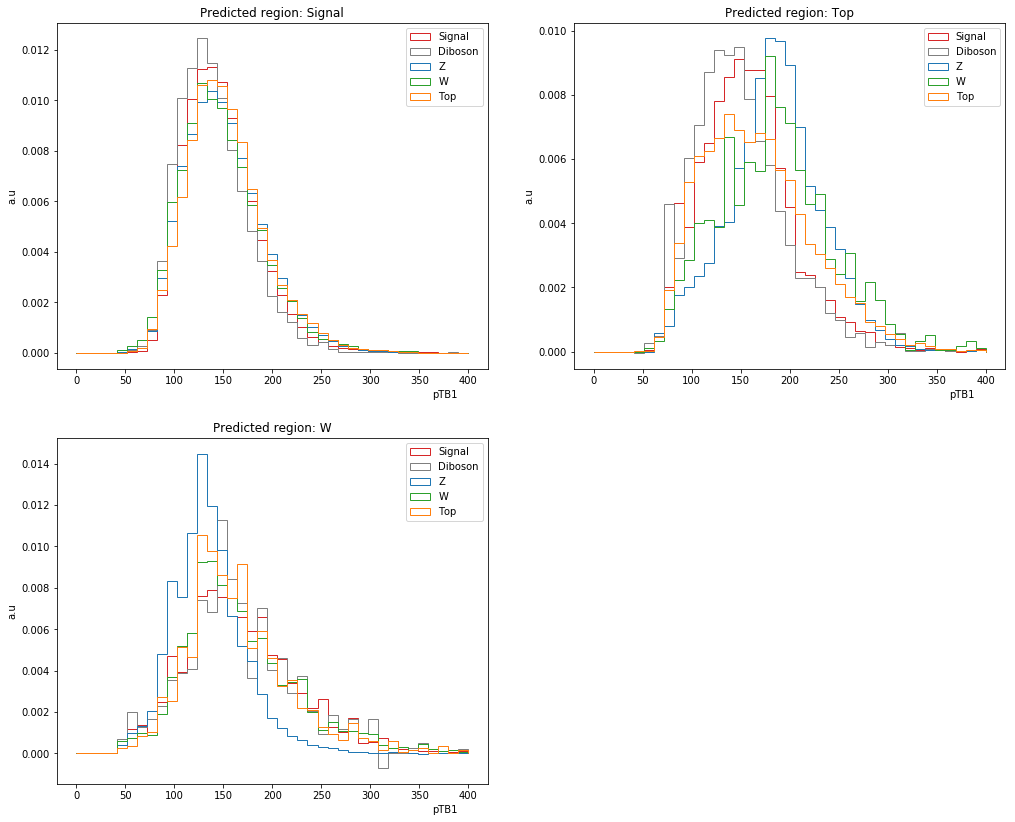

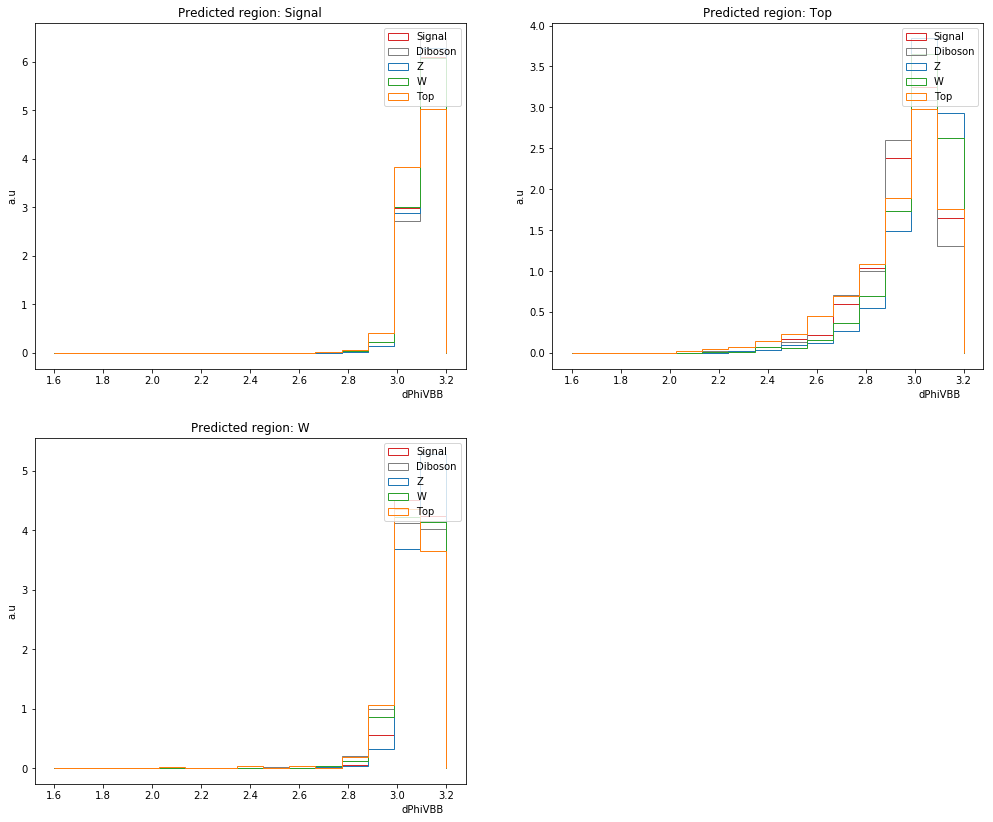

In [49]:
show_plots = True

variables = ["mBB", "dRBB", "pTB1", "pTB2", "MET", "dPhiVBB", "dEtaBB", "MEff", "nTaus"] 

for var in variables:
    
    fig, axes = plt.subplots(2, 2, figsize=(17, 14)) #Axes are numerated from 0 to 3.
    axes = axes.ravel()

    for predicted_region in [1,2,3]: #Signal, Top CR, W CR

        plt.sca(axes[predicted_region-1])

        #The test sample contains half of the events. Should multiplied for 2 to get back yields.
        SignalVarForPredicedClass       = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)][var]
        SignalWeightsForPredicedClass   = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 1) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]
        TopVarForPredicedClass          = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)][var]
        TopWeightsForPredicedClass      = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 2) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]
        WVarForPredicedClass            = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)][var]
        WWeightsForPredicedClass        = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 3) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]
        ZVarForPredicedClass            = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)][var]
        ZWeightsForPredicedClass        = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 4) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]
        DibosonVarForPredicedClass      = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)][var]
        DibosonWeightsForPredicedClass  = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == 5) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]

        plt.hist([TopVarForPredicedClass, WVarForPredicedClass, ZVarForPredicedClass, DibosonVarForPredicedClass, SignalVarForPredicedClass], 
                  bins[var], 
                  weights = [TopWeightsForPredicedClass, WWeightsForPredicedClass, ZWeightsForPredicedClass, DibosonWeightsForPredicedClass, SignalWeightsForPredicedClass], 
                  color = [colors[2], colors[3], colors[4], colors[5], colors[1]],
                  ###Hist type###
                  histtype = 'step', 
                  stacked = False,
                  density = True,
                  ###############
                  label = ['Top','W','Z','Diboson','Signal'],
                )

        plt.gca().legend()
        plt.title('Predicted region: ' + str(region_names[predicted_region]), x=0.5, y=1)
        plt.xlabel(var, x=0.9, y=0.6)
        #plt.ylabel('yields')
        plt.ylabel('a.u')
        #plt.ylim((0,1000))
        

    fig.delaxes(axes[3]) #Delete the sixth canvas.     
    fig.savefig(plot_dir +  var + '_in_signal_and_CR_regions.pdf')
    
    if show_plots == False:
        plt.close()

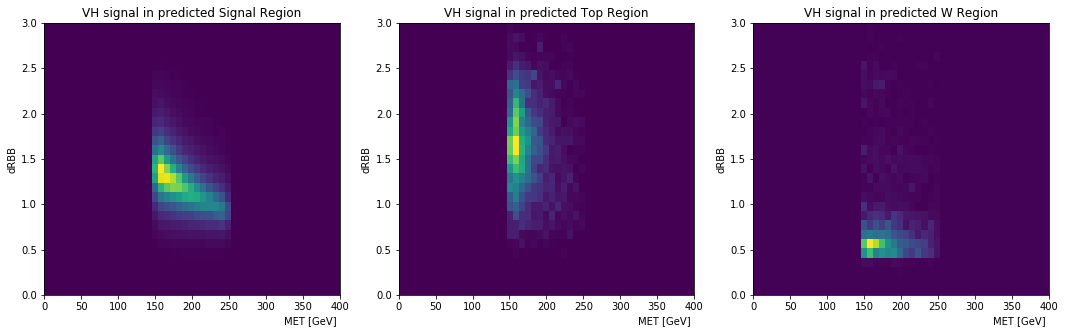

In [199]:
show_plots = True

variables = ["mBB"] 

for process in [1]: #[1,2,3,4,5]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) #Axes are numerated from 0 to 3.
    axes = axes.ravel()

    for predicted_region in [1,2,3]: #Signal, Top CR, W CR

        plt.sca(axes[predicted_region-1])

        METForPredicedClass       = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == process) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]['MET']
        dRBBForPredicedClass      = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == process) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]['dRBB']
        WeightsForPredicedClass   = DataFrame_test_fold12[(DataFrame_test_fold12["Class"] == process) & (DataFrame_test_fold12["isTopOrWCR"] == predicted_region)]["EventWeight"]

        plt.hist2d(METForPredicedClass,
                  dRBBForPredicedClass,
                  bins = [bins['MET'], bins['dRBB']], 
                  weights = WeightsForPredicedClass, 
                )

        #plt.title(region_names[process] + ' process in predicted region: ' + str(region_names[predicted_region]), x=0.5, y=1)
        plt.title('VH signal in predicted ' + str(region_names[predicted_region]) + ' Region', x=0.5, y=1)
        plt.xlabel('MET [GeV]', x=0.9, y=0.6)
        plt.ylabel('dRBB')
        
    
    #axes[3].set_visible(False)
    #fig.delaxes(axes[3]) #Delete the sixth canvas.     
    
    if show_plots == False:
        plt.close()
        
    fig.savefig(plot_dir + 'MET_dRBB_regions.pdf')